In [29]:
"""Encoding categorical data."""

'Encoding categorical data.'

# Кодирование категориальных переменных

In [30]:
import io
import os

import category_encoders as ce
import jenkspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from dotenv import load_dotenv
from scipy.stats import binned_statistic
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)

In [31]:
scoring = {
    "Name": ["Иван", "Николай", "Алексей", "Александра", "Евгений", "Елена"],
    "Age": [35, 43, 21, 34, 24, 27],
    "City": [
        "Москва",
        "Нижний Новгород",
        "Санкт-Петербург",
        "Владивосток",
        "Москва",
        "Екатеринбург",
    ],
    "Experience": [7, 13, 2, 8, 4, 12],
    "Salary": [95, 135, 73, 100, 78, 110],
    "Credit_score": ["Good", "Good", "Bad", "Medium", "Medium", "Good"],
    "Outcome": ["Вернул", "Вернул", "Не вернул", "Вернул", "Не вернул", "Вернул"],
}

df = pd.DataFrame(scoring)
df

,Name,Age,City,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,7,95,Good,Вернул
1,Николай,43,Нижний Новгород,13,135,Good,Вернул
2,Алексей,21,Санкт-Петербург,2,73,Bad,Не вернул
3,Александра,34,Владивосток,8,100,Medium,Вернул
4,Евгений,24,Москва,4,78,Medium,Не вернул
5,Елена,27,Екатеринбург,12,110,Good,Вернул


## Еще раз про категориальные данные

### `.info()`, `.unique()`, `.value_counts()`

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          6 non-null      object
 1   Age           6 non-null      int64 
 2   City          6 non-null      object
 3   Experience    6 non-null      int64 
 4   Salary        6 non-null      int64 
 5   Credit_score  6 non-null      object
 6   Outcome       6 non-null      object
dtypes: int64(3), object(4)
memory usage: 468.0+ bytes


In [33]:
df.dtypes

Name            object
Age              int64
City            object
Experience       int64
Salary           int64
Credit_score    object
Outcome         object
dtype: object

In [34]:
df.City.unique()

array(['Москва', 'Нижний Новгород', 'Санкт-Петербург', 'Владивосток',
       'Екатеринбург'], dtype=object)

In [35]:
# метод .value_counts() сортирует категории по количеству объектов
# в убывающем порядке
df.City.value_counts()

City
Москва             2
Нижний Новгород    1
Санкт-Петербург    1
Владивосток        1
Екатеринбург       1
Name: count, dtype: int64

In [36]:
np.unique(df.City, return_counts=True)

(array(['Владивосток', 'Екатеринбург', 'Москва', 'Нижний Новгород',
        'Санкт-Петербург'], dtype=object),
 array([1, 1, 2, 1, 1]))

In [37]:
# посмотрим на общее количество уникальных категорий
df.City.value_counts().count()

np.int64(5)

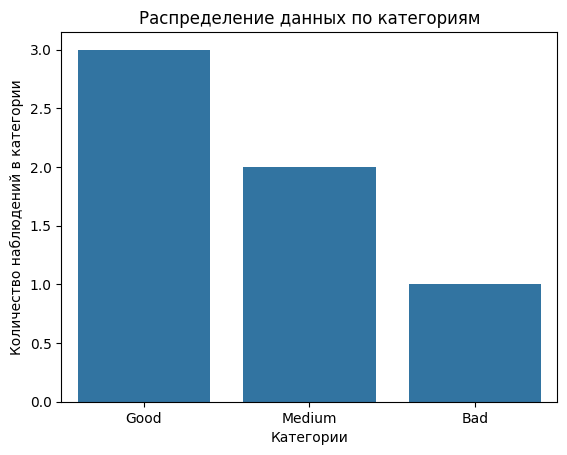

In [38]:
score_counts = df.Credit_score.value_counts()
sns.barplot(x=score_counts.index, y=score_counts.values)
plt.title("Распределение данных по категориям")
plt.ylabel("Количество наблюдений в категории")
plt.xlabel("Категории");

### Тип данных 'category'

In [39]:
df = df.astype({"City": "category", "Outcome": "category"})

In [40]:
df.Credit_score = pd.Categorical(
    df.Credit_score, categories=["Bad", "Medium", "Good"], ordered=True
)

In [41]:
df.Credit_score.cat.categories

Index(['Bad', 'Medium', 'Good'], dtype='object')

In [42]:
df.Credit_score.dtype

CategoricalDtype(categories=['Bad', 'Medium', 'Good'], ordered=True, categories_dtype=object)

In [43]:
df.Credit_score.cat.codes

0    2
1    2
2    0
3    1
4    1
5    2
dtype: int8

In [44]:
df.Outcome = df.Outcome.cat.rename_categories(
    new_categories={"Вернул": "Yes", "Не вернул": "No"}
)

df

,Name,Age,City,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,7,95,Good,Yes
1,Николай,43,Нижний Новгород,13,135,Good,Yes
2,Алексей,21,Санкт-Петербург,2,73,Bad,No
3,Александра,34,Владивосток,8,100,Medium,Yes
4,Евгений,24,Москва,4,78,Medium,No
5,Елена,27,Екатеринбург,12,110,Good,Yes


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Name          6 non-null      object  
 1   Age           6 non-null      int64   
 2   City          6 non-null      category
 3   Experience    6 non-null      int64   
 4   Salary        6 non-null      int64   
 5   Credit_score  6 non-null      category
 6   Outcome       6 non-null      category
dtypes: category(3), int64(3), object(1)
memory usage: 810.0+ bytes


### Кардинальность данных

In [46]:
region = np.where(((df.City == "Екатеринбург") | (df.City == "Владивосток")), 0, 1)
df.insert(loc=3, column="Region", value=region)

df

,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,1,7,95,Good,Yes
1,Николай,43,Нижний Новгород,1,13,135,Good,Yes
2,Алексей,21,Санкт-Петербург,1,2,73,Bad,No
3,Александра,34,Владивосток,0,8,100,Medium,Yes
4,Евгений,24,Москва,1,4,78,Medium,No
5,Елена,27,Екатеринбург,0,12,110,Good,Yes


## Базовые методы кодирования

### Кодирование через `cat.codes`

In [47]:
df_cat = df.copy()
df_cat.Credit_score.cat.codes

0    2
1    2
2    0
3    1
4    1
5    2
dtype: int8

In [48]:
df_cat.Credit_score = df_cat.Credit_score.astype("category").cat.codes
df_cat

,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,1,7,95,2,Yes
1,Николай,43,Нижний Новгород,1,13,135,2,Yes
2,Алексей,21,Санкт-Петербург,1,2,73,0,No
3,Александра,34,Владивосток,0,8,100,1,Yes
4,Евгений,24,Москва,1,4,78,1,No
5,Елена,27,Екатеринбург,0,12,110,2,Yes


### Mapping

In [49]:
df_map = df.copy()

# ключами будут старые значения признака
# значениями словаря - новые значения признака
map_dict = {"Bad": 0, "Medium": 1, "Good": 2}

df_map["Credit_score"] = df_map["Credit_score"].map(map_dict)
df_map

,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,1,7,95,2,Yes
1,Николай,43,Нижний Новгород,1,13,135,2,Yes
2,Алексей,21,Санкт-Петербург,1,2,73,0,No
3,Александра,34,Владивосток,0,8,100,1,Yes
4,Евгений,24,Москва,1,4,78,1,No
5,Елена,27,Екатеринбург,0,12,110,2,Yes


In [50]:
# fmt: off
# сделаем еще одну копию датафрейма
df_map = df.copy()

df_map["Credit_score"] = df_map["Credit_score"].map(
    {"Bad": 0, "Medium": 1, "Good": 2}
)
df_map
# fmt: on

,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,1,7,95,2,Yes
1,Николай,43,Нижний Новгород,1,13,135,2,Yes
2,Алексей,21,Санкт-Петербург,1,2,73,0,No
3,Александра,34,Владивосток,0,8,100,1,Yes
4,Евгений,24,Москва,1,4,78,1,No
5,Елена,27,Екатеринбург,0,12,110,2,Yes


### Label Encoder

In [51]:
labelencoder = LabelEncoder()

df_le = df.copy()

# на вход принимает только одномерные массивы
df_le.loc[:, "Outcome"] = labelencoder.fit_transform(df_le.loc[:, "Outcome"])
df_le

C:\Users\Ruslan\AppData\Local\Temp\ipykernel_9580\3455497389.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 1 0 1]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_le.loc[:, "Outcome"] = labelencoder.fit_transform(df_le.loc[:, "Outcome"])


,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,1,7,95,Good,1
1,Николай,43,Нижний Новгород,1,13,135,Good,1
2,Алексей,21,Санкт-Петербург,1,2,73,Bad,0
3,Александра,34,Владивосток,0,8,100,Medium,1
4,Евгений,24,Москва,1,4,78,Medium,0
5,Елена,27,Екатеринбург,0,12,110,Good,1


In [52]:
# применим LabelEncoder к номинальной переменной City
df_le.loc[:, "City"] = labelencoder.fit_transform(df_le.loc[:, "City"])
df_le

C:\Users\Ruslan\AppData\Local\Temp\ipykernel_9580\4156843044.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 3 4 0 2 1]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_le.loc[:, "City"] = labelencoder.fit_transform(df_le.loc[:, "City"])


,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,2,1,7,95,Good,1
1,Николай,43,3,1,13,135,Good,1
2,Алексей,21,4,1,2,73,Bad,0
3,Александра,34,0,0,8,100,Medium,1
4,Евгений,24,2,1,4,78,Medium,0
5,Елена,27,1,0,12,110,Good,1


In [53]:
# применим LabelEncoder к номинальной переменной Credit_score
df_le.loc[:, "Credit_score"] = labelencoder.fit_transform(df_le.loc[:, "Credit_score"])
df_le

C:\Users\Ruslan\AppData\Local\Temp\ipykernel_9580\3980189787.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 2 2 1]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_le.loc[:, "Credit_score"] = labelencoder.fit_transform(df_le.loc[:, "Credit_score"])


,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,2,1,7,95,1,1
1,Николай,43,3,1,13,135,1,1
2,Алексей,21,4,1,2,73,0,0
3,Александра,34,0,0,8,100,2,1
4,Евгений,24,2,1,4,78,2,0
5,Елена,27,1,0,12,110,1,1


In [54]:
# порядок нарушен
labelencoder.classes_

array(['Bad', 'Good', 'Medium'], dtype=object)

### Ordinal Encoder

In [ ]:
ordinalencoder = OrdinalEncoder(categories=[["Bad", "Medium", "Good"]])

df_oe = df.copy()

# используем метод .to_frame() для преобразования Series в датафрейм
df_oe.loc[:, "Credit_score"] = ordinalencoder.fit_transform(
    df_oe.loc[:, "Credit_score"].to_frame()  # type: ignore[operator]
)
df_oe

C:\Users\Ruslan\AppData\Local\Temp\ipykernel_9580\298067261.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2. 2. 0. 1. 1. 2.]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_oe.loc[:, "Credit_score"] = ordinalencoder.fit_transform(


,Name,Age,City,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,Москва,1,7,95,2.0,Yes
1,Николай,43,Нижний Новгород,1,13,135,2.0,Yes
2,Алексей,21,Санкт-Петербург,1,2,73,0.0,No
3,Александра,34,Владивосток,0,8,100,1.0,Yes
4,Евгений,24,Москва,1,4,78,1.0,No
5,Елена,27,Екатеринбург,0,12,110,2.0,Yes


In [56]:
ordinalencoder.categories_

[array(['Bad', 'Medium', 'Good'], dtype=object)]

### One Hot Encoding

#### класс OneHotEncoder

In [57]:
df_onehot = df.copy()


# создадим объект класса OneHotEncoder
# параметр sparse = True выдал бы результат в сжатом формате
onehotencoder = OneHotEncoder(sparse_output=False)

encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[["City"]]))
encoded_df

,0,1,2,3,4
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0


In [58]:
onehotencoder.get_feature_names_out()

array(['City_Владивосток', 'City_Екатеринбург', 'City_Москва',
       'City_Нижний Новгород', 'City_Санкт-Петербург'], dtype=object)

In [59]:
encoded_df.columns = onehotencoder.get_feature_names_out()
encoded_df

,City_Владивосток,City_Екатеринбург,City_Москва,City_Нижний Новгород,City_Санкт-Петербург
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0


In [60]:
df_onehot = df_onehot.join(encoded_df)
df_onehot.drop("City", axis=1, inplace=True)

In [61]:
df_onehot = df.copy()

# чтобы удалить первый признак, используем параметр drop = 'first'
onehot_first = OneHotEncoder(drop="first", sparse_output=False)

encoded_df = pd.DataFrame(onehot_first.fit_transform(df_onehot[["City"]]))
encoded_df.columns = onehot_first.get_feature_names_out()

df_onehot = df_onehot.join(encoded_df)
df_onehot.drop("Outcome", axis=1, inplace=True)
df_onehot

,Name,Age,City,Region,Experience,Salary,Credit_score,City_Екатеринбург,City_Москва,City_Нижний Новгород,City_Санкт-Петербург
0,Иван,35,Москва,1,7,95,Good,0.0,1.0,0.0,0.0
1,Николай,43,Нижний Новгород,1,13,135,Good,0.0,0.0,1.0,0.0
2,Алексей,21,Санкт-Петербург,1,2,73,Bad,0.0,0.0,0.0,1.0
3,Александра,34,Владивосток,0,8,100,Medium,0.0,0.0,0.0,0.0
4,Евгений,24,Москва,1,4,78,Medium,0.0,1.0,0.0,0.0
5,Елена,27,Екатеринбург,0,12,110,Good,1.0,0.0,0.0,0.0


#### `pd.get_dummies()`

In [62]:
df_dum = df.copy()
pd.get_dummies(df_dum, columns=["City"])

,Name,Age,Region,Experience,Salary,Credit_score,Outcome,City_Владивосток,City_Екатеринбург,City_Москва,City_Нижний Новгород,City_Санкт-Петербург
0,Иван,35,1,7,95,Good,Yes,False,False,True,False,False
1,Николай,43,1,13,135,Good,Yes,False,False,False,True,False
2,Алексей,21,1,2,73,Bad,No,False,False,False,False,True
3,Александра,34,0,8,100,Medium,Yes,True,False,False,False,False
4,Евгений,24,1,4,78,Medium,No,False,False,True,False,False
5,Елена,27,0,12,110,Good,Yes,False,True,False,False,False


In [63]:
pd.get_dummies(df_dum, columns=["City"], prefix="", prefix_sep="")

,Name,Age,Region,Experience,Salary,Credit_score,Outcome,Владивосток,Екатеринбург,Москва,Нижний Новгород,Санкт-Петербург
0,Иван,35,1,7,95,Good,Yes,False,False,True,False,False
1,Николай,43,1,13,135,Good,Yes,False,False,False,True,False
2,Алексей,21,1,2,73,Bad,No,False,False,False,False,True
3,Александра,34,0,8,100,Medium,Yes,True,False,False,False,False
4,Евгений,24,1,4,78,Medium,No,False,False,True,False,False
5,Елена,27,0,12,110,Good,Yes,False,True,False,False,False


In [64]:
pd.get_dummies(df_dum, columns=["City"], prefix="", prefix_sep="", drop_first=True)

,Name,Age,Region,Experience,Salary,Credit_score,Outcome,Екатеринбург,Москва,Нижний Новгород,Санкт-Петербург
0,Иван,35,1,7,95,Good,Yes,False,True,False,False
1,Николай,43,1,13,135,Good,Yes,False,False,True,False
2,Алексей,21,1,2,73,Bad,No,False,False,False,True
3,Александра,34,0,8,100,Medium,Yes,False,False,False,False
4,Евгений,24,1,4,78,Medium,No,False,True,False,False
5,Елена,27,0,12,110,Good,Yes,True,False,False,False


#### Библиотека category_encoders

In [65]:
# установим библиотеку
!pip install category_encoders

In [66]:
df_catenc = df.copy()


# в параметр cols передадим столбцы, которые нужно преобразовать
ohe_encoder = ce.OneHotEncoder(cols=["City"])
# в метод .fit_transform() мы передадим весь датафрейм целиком
df_catenc = ohe_encoder.fit_transform(df_catenc)
df_catenc

,Name,Age,City_1,City_2,City_3,City_4,City_5,Region,Experience,Salary,Credit_score,Outcome
0,Иван,35,1,0,0,0,0,1,7,95,Good,Yes
1,Николай,43,0,1,0,0,0,1,13,135,Good,Yes
2,Алексей,21,0,0,1,0,0,1,2,73,Bad,No
3,Александра,34,0,0,0,1,0,0,8,100,Medium,Yes
4,Евгений,24,1,0,0,0,0,1,4,78,Medium,No
5,Елена,27,0,0,0,0,1,0,12,110,Good,Yes


#### Сравнение инструментов

In [67]:
train = pd.DataFrame({"recom": ["yes", "no", "maybe"]})
train

,recom
0,yes
1,no
2,maybe


In [68]:
test = pd.DataFrame({"recom": ["yes", "no", "yes"]})
test

,recom
0,yes
1,no
2,yes


##### `pd.get_dummies()`

In [69]:
pd.get_dummies(train)

,recom_maybe,recom_no,recom_yes
0,False,False,True
1,False,True,False
2,True,False,False


In [70]:
pd.get_dummies(test)

,recom_no,recom_yes
0,False,True
1,True,False
2,False,True


##### OHE sklearn

In [71]:
ohe = OneHotEncoder()
ohe_model = ohe.fit(train)
ohe_model.categories_

[array(['maybe', 'no', 'yes'], dtype=object)]

In [72]:
train_arr = ohe_model.transform(train).toarray()
pd.DataFrame(train_arr, columns=["maybe", "no", "yes"])

,maybe,no,yes
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0


In [73]:
test_arr = ohe_model.transform(test).toarray()
pd.DataFrame(test_arr, columns=["maybe", "no", "yes"])

,maybe,no,yes
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [74]:
ohe = OneHotEncoder()
ohe_model = ohe.fit(test)
ohe_model.categories_

[array(['no', 'yes'], dtype=object)]

##### OHE category_encoders

In [75]:
ohe_encoder = ce.OneHotEncoder()
ohe_encoder.fit(train)

OneHotEncoder(cols=['recom'])

In [76]:
# категория maybe стоит на последнем месте
ohe_encoder.transform(test)

,recom_1,recom_2,recom_3
0,1,0,0
1,0,1,0
2,1,0,0


In [77]:
# убедимся в этом, добавив названия столбцов
test_df = ohe_encoder.transform(test)
test_df.columns = ohe_encoder.category_mapping[0]["mapping"].index[:3]
test_df

,1,2,3
0,1,0,0
1,0,1,0
2,1,0,0


## Binning/bucketing

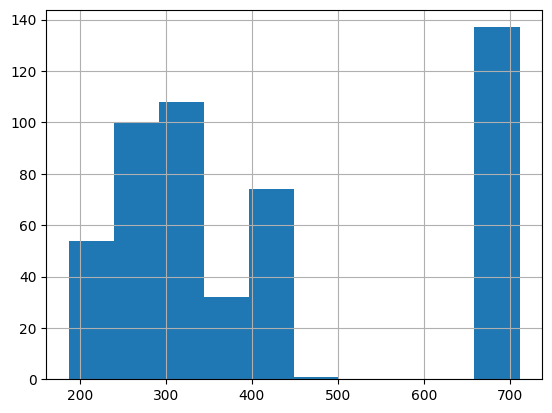

In [ ]:
load_dotenv()

boston_csv_url = os.environ.get("BOSTON_CSV_URL", "")
response = requests.get(boston_csv_url)
boston = pd.read_csv(io.BytesIO(response.content))
boston.TAX.hist();

### На равные интервалы

In [79]:
min_value = boston.TAX.min()
max_value = boston.TAX.max()

bins = np.linspace(min_value, max_value, 4)
bins

array([187.        , 361.66666667, 536.33333333, 711.        ])

In [80]:
labels = ["low", "medium", "high"]

In [81]:
boston["TAX_binned"] = pd.cut(
    boston.TAX,
    bins=bins,
    labels=labels,
    # уточним, что первый интервал должен включать
    # нижнуюю границу (значение 187)
    include_lowest=True,
)

In [82]:
boston[["TAX", "TAX_binned"]].sample(5, random_state=42)

,TAX,TAX_binned
173,296.0,low
274,254.0,low
491,711.0,high
72,305.0,low
452,666.0,high


In [83]:
boston.TAX.value_counts(bins=3, sort=False)

(186.475, 361.667]    273
(361.667, 536.333]     96
(536.333, 711.0]      137
Name: count, dtype: int64

### По квантилям

In [84]:
# для наглядности вначале найдем интересующие нас квантили
np.quantile(boston.TAX, q=[1 / 3, 2 / 3])

array([300., 403.])

In [85]:
boston["TAX_qbinned"], boundaries = pd.qcut(
    boston.TAX,
    q=3,
    # precision определяет округление
    precision=1,
    labels=labels,
    retbins=True,
)

boundaries

array([187., 300., 403., 711.])

In [86]:
boston[["TAX", "TAX_qbinned"]].sample(5, random_state=42)

,TAX,TAX_qbinned
173,296.0,low
274,254.0,low
491,711.0,high
72,305.0,medium
452,666.0,high


In [87]:
boston.TAX_qbinned.value_counts()

TAX_qbinned
low       172
high      168
medium    166
Name: count, dtype: int64

### KBinsDiscretizer

#### strategy = 'uniform'

In [88]:
est = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform", subsample=None)

est.fit(boston[["TAX"]])
est.bin_edges_

array([array([187.        , 361.66666667, 536.33333333, 711.        ])],
      dtype=object)

In [89]:
np.unique(est.transform(boston[["TAX"]]), return_counts=True)

(array([0., 1., 2.]), array([273,  96, 137]))

#### strategy = 'quantile'

In [90]:
est = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
est.fit(boston[["TAX"]])
est.bin_edges_

array([array([187., 300., 403., 711.])], dtype=object)

In [91]:
np.unique(est.transform(boston[["TAX"]]), return_counts=True)

(array([0., 1., 2.]), array([165, 143, 198]))

#### strategy = 'kmeans'

In [92]:
est = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="kmeans", subsample=None)

est.fit(boston[["TAX"]])
est.bin_edges_

array([array([187.        , 338.7198937 , 535.07350433, 711.        ])],
      dtype=object)

In [93]:
np.unique(est.transform(boston[["TAX"]]), return_counts=True)

(array([0., 1., 2.]), array([262, 107, 137]))

### С помощью статистических показателей

In [94]:
medians, bin_edges, _ = binned_statistic(
    boston.TAX, np.arange(0, len(boston)), statistic="median", bins=3
)

medians, bin_edges

(array([216. , 147.5, 424. ]),
 array([187.        , 361.66666667, 536.33333333, 711.        ]))

In [95]:
boston["TAX_binned_median"] = pd.cut(
    boston.TAX, bins=bin_edges, labels=medians, include_lowest=True
)

boston["TAX_binned_median"].value_counts()

TAX_binned_median
216.0    273
424.0    137
147.5     96
Name: count, dtype: int64

### Алгоритм Дженкса

In [96]:
!pip install jenkspy

In [97]:
breaks = jenkspy.jenks_breaks(boston.TAX, n_classes=3)
breaks

[np.float64(187.0), np.float64(337.0), np.float64(469.0), np.float64(711.0)]

In [98]:
boston["TAX_binned_jenks"] = pd.cut(
    boston.TAX, bins=breaks, labels=labels, include_lowest=True
)

boston["TAX_binned_jenks"].value_counts()

TAX_binned_jenks
low       262
high      137
medium    107
Name: count, dtype: int64